# Модель химических реакций Робертсона

Жесткая система ОДУ имени Робертсона имеет вид:

$$
  \dot{y}_1 = -0.04 y_1 + 10^4 y_2 y_3,
$$

$$
  \dot{y}_2 = 0.04 y_1 - 10^4 y_2 y_3 - 3 \cdot 10^7 y_2^2,
$$

$$
  \dot{y}_3 = 3 \cdot 10^7 y_2^2
$$

Начальные условия для системы таковы: 
$$
  y_1(0) = 1, \hspace{1cm}
  y_2(0) = 0, \hspace{1cm}
  y_3(0) = 0
$$

Рассматриваются следующие величины отрезка интегрирования: $T_k = 40$ (В работе Робертсона рассматривался именно такой отрезок интегрирования), $T_k = 100, 1000, ..., 10^{11}$.

# Необходимые функции

In [22]:
import numpy as np
import matplotlib.pyplot as plt

Обсчет ОДУ и начальные условия:

In [23]:
def differentialEquation(Y):
  y1 = Y[0]
  y2 = Y[1]
  y3 = Y[2]

  return np.array([
                   (-0.04 * y1) + (10**4 * y2 * y3),
                   (0.04 * y1) - (10**4 * y2 * y3) - (3 * 10**7 * y2**2),
                   3 * 10**7 * y2**2
  ])

initial_conditions = np.array([1, 0, 0], np.float64)

Функция для построения графиков

In [24]:
def drawPlots(flow, time):
  Y1 = []
  Y2 = []
  Y3 = []
  for flow_point in flow:
    Y1.append(flow_point[0])
    Y2.append(flow_point[1])
    Y3.append(flow_point[2])

  time_scale = np.linspace(0, time, len(flow))

  plt.figure(figsize=[12, 8])
  plt.grid()
  plt.title(f'Process flow for $T_k$ = {time}')
  plt.plot(time_scale, Y1, label='$y_1(t)$')
  plt.plot(time_scale, Y2, label='$y_2(t)$')
  plt.plot(time_scale, Y3, label='$y_3(t)$')
  plt.legend()
  plt.xlabel('$t$, Time')
  plt.ylabel('$y$, Concentration')

  plt.figure(figsize=[12, 8])
  plt.grid()
  plt.title(f'Separate plot for $T_k$ = {time}')
  plt.plot(time_scale, Y2, label='$y(t)$')
  plt.legend()
  plt.xlabel('$t$, Time')
  plt.ylabel('$y$, Concentration')

# Явный метод Рунге-Кутты

In [25]:
class RungeCutt:
  class ButcherTable:
    def __init__(self, rank):
      self.rank = rank
      self.setTable()

    def setTable(self):
      if (self.rank == 1):
        self.a = [[0, 0], [1, 0]]
        self.b = [0, 1]
        self.c = [0, 1]
      elif (self.rank == 2):
        self.a = [[0, 0], [1/2, 0]]
        self.b = [0, 1]
        self.c = [0, 1/2]
      elif (self.rank == 3):
        self.a = [[0, 0, 0], [1/3, 0, 0], [0, 2/3, 0]]
        self.b = [1/4, 0, 3/4]
        self.c = [0, 1/3, 2/3]
      elif (self.rank == 4):
        self.a = [[0, 0, 0, 0], [1/2, 0, 0, 0], [0, 1/2, 0, 0], [0, 0, 1, 0]]
        self.b = [1/6, 2/6, 2/6, 1/6]
        self.c = [0, 1/2, 1/2, 1]

  def __init__(self, function, rank, initial_position, h = 0.01, max_time = 20):
    self.function = function
    self.rank = rank
    self.h = h
    self.butcher_table = self.ButcherTable(self.rank)

    self.initial_position = initial_position.copy()
    self.X = self.initial_position.copy()

    self.time = 0
    self.max_time = max_time

    self.trajectory = [self.initial_position]

  def getKMassive(self):
    k_mass = []
    for i in range(0, self.rank):
      k = self.function(self.X + 
                        sum([self.butcher_table.a[j+1][j] * 
                             self.h * k_mass[j]
                             for j in range(0, i)
                        ]))
      k_mass.append(k)
    return k_mass

  def getNextPoint(self):
    k_mass = self.getKMassive()
    self.X += sum([self.h * self.butcher_table.b[i] * k_mass[i] 
                   for i in range(0, self.rank)])
    self.time += self.h
    return self.X.copy()

  def calcTrajectory(self):
    self.trajectory = [self.initial_position]
    while self.time < self.max_time:
      self.trajectory.append(self.getNextPoint())

    return self.trajectory

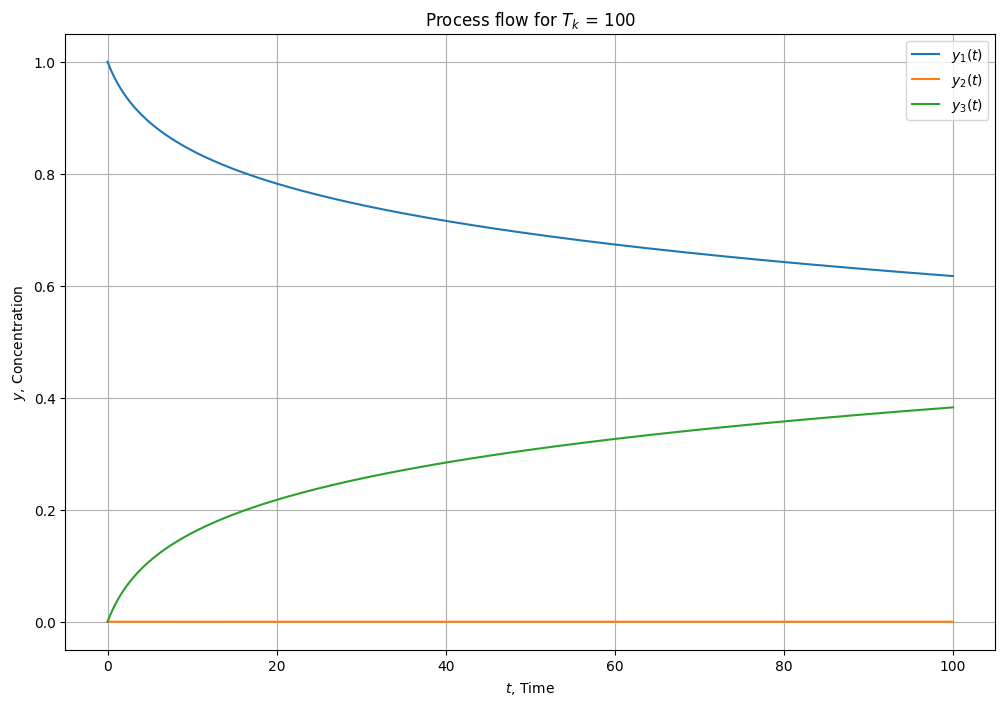

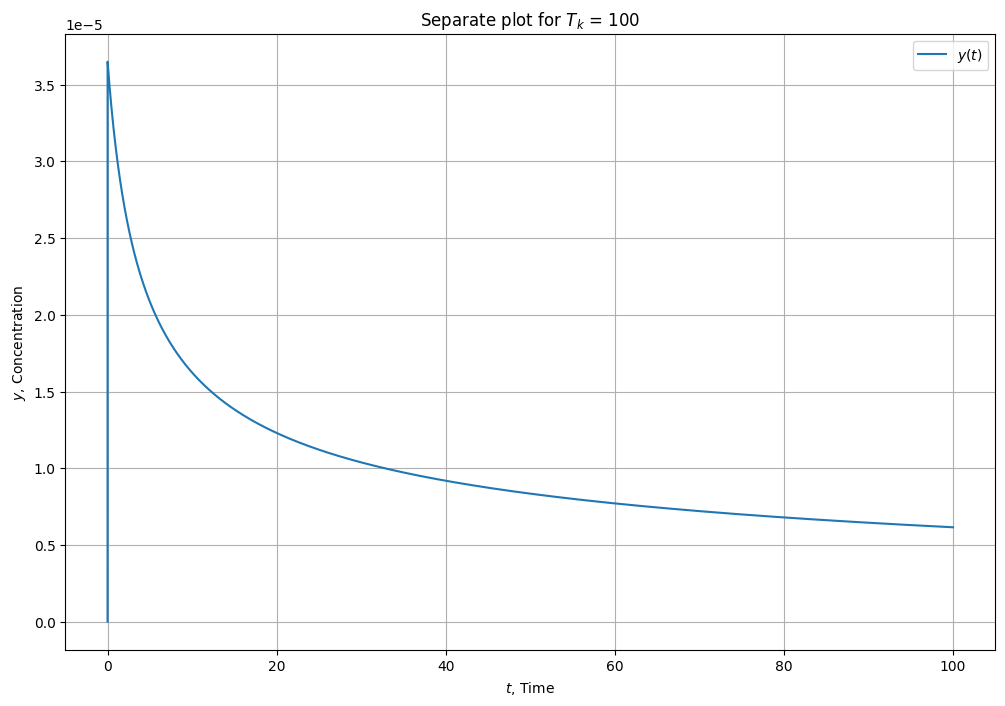

In [27]:
time = 100
rk = RungeCutt(differentialEquation, 2, initial_conditions, h=0.0001, max_time=time)
drawPlots(rk.calcTrajectory(), time)

# Решение через неявный метод

In [14]:
def predict(Y, function, h = 0.001):
  return Y + h * function(Y)

def correct(Y, Y_predicted, function, h = 0.001):
  return Y + h * 0.5 * (function(Y) + function(Y_predicted))

def getNextFlowPoint(Y, function, h = 0.001, accuracy = 0.001):
  Y_predicted = predict(Y, function, h)
  Y_corrected = correct(Y, Y_predicted, function, h)

  while np.sum(np.abs(Y_corrected - Y_predicted)) > accuracy:
    Y_predicted = Y_corrected.copy()
    Y_corrected = correct(Y, Y_predicted, function, h).copy()

  return Y_corrected

def buildFlow(Y_start, function, max_time, h = 0.001, accuracy = 0.001):
  time = 0
  Y = Y_start.copy()
  flow = [Y.copy()]

  while time < max_time:
    Y = getNextFlowPoint(Y.copy(), function, h, accuracy).copy()
    flow.append(Y.copy())
    time += h

  return flow

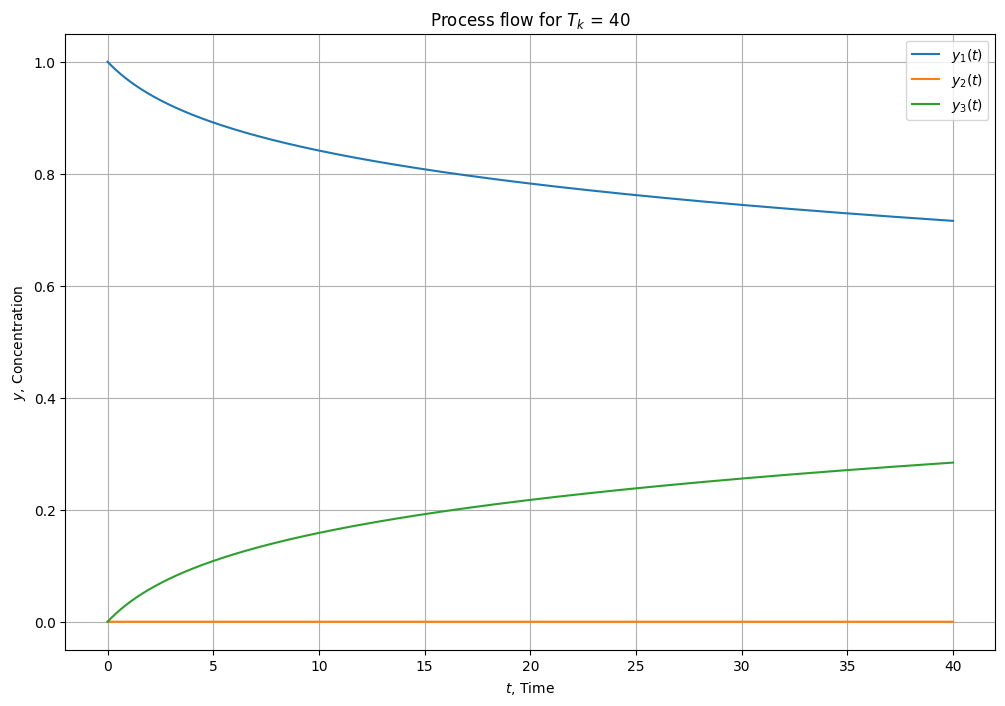

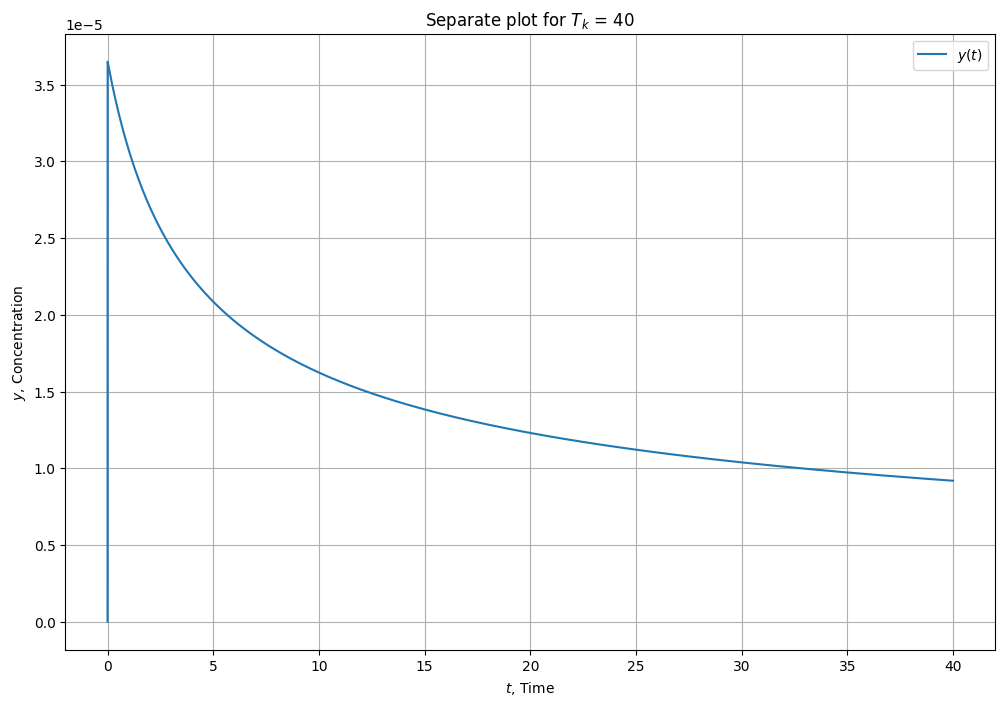

In [15]:
max_time = 40
flow = buildFlow(initial_conditions, differentialEquation, max_time, h = 0.0001)
drawPlots(flow, max_time)

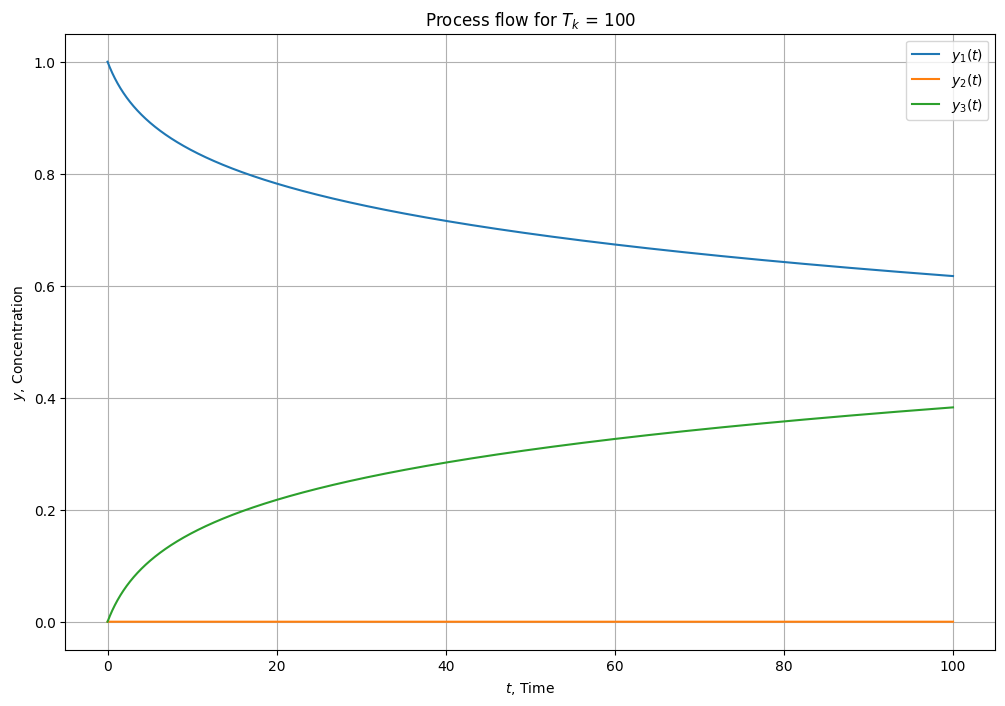

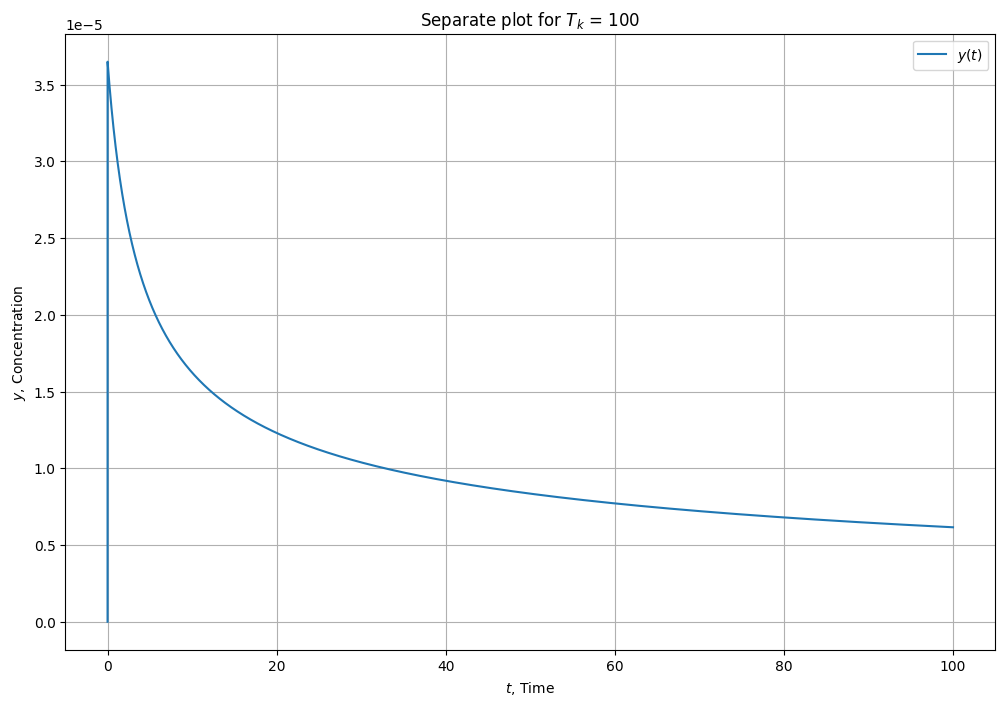

In [16]:
max_time = 100
flow = buildFlow(initial_conditions, differentialEquation, max_time, h = 0.0001)
drawPlots(flow, max_time)